# This notebook shows how to use `autodp` to track differential privacy losses.

## 1. Installation and import
Simply type in the terminal
`pip install autodp`

In [1]:
# Import package
from autodp import rdp_bank, rdp_acct, dp_acct,privacy_calibrator


## 2. Declare the data structure for tracking privacy loss

`autodp` has two privacy loss trackers:  `dp_acct.DP_Acct` that tracks a fixed sequence of $(\epsilon,\delta)$ and `rdp_acct.anaRDPacct` that tracks the entire family of $(\epsilon,\delta)$ through the analytical expression of the Renyi Differential Privacy, or (up to scaling) equivalently, the CGF (log-MGF) of the privacy random variable:
$$
\log\Big(\frac{p(x)}{q(x)}\Big)
$$
induces ed by $x\sim p$.

We will be mostly demostrating the latter for now.

In [2]:
# declare the moment accountants
acct = rdp_acct.anaRDPacct()

## 3. Obtain an analytical RDP for popular privacy mechanisms using `rdp_bank`

The input to `anRDPacct` is in fact lambda functions that output the evaluations of the CGF that comes from.

To make our lives easy, `rdp_bank` implements the CCF of most popular differentially private algorithms
    * Laplace mechanism
    * Gaussian mechanism
    * Randomized response
    * pDP of two Multivariate Gaussians
    * pDP of two Exponential Family

Each of these would take a set of parameters as input in a dictionary form. For example, the Gaussian mechanism will take the ratio between the noise std and the L2 sensitivity of the function to be released.

In [3]:
# A few example of these lambda functions here

sigma = 5.0
b = 2.0
p = 0.7

# get the CGF functions
func_gaussian = lambda x: rdp_bank.RDP_gaussian({'sigma': sigma}, x)
func_laplace = lambda x: rdp_bank.RDP_laplace({'b': b}, x)
func_randresp = lambda x: rdp_bank.RDP_randresponse({'p':p},x)



## 4. Now mix and match and track their RDP using `anaRDPacct.compose_mechanism` and get the smallest $\epsilon$ for your chosen $\delta$

In [4]:
acct.compose_mechanism(func_randresp)
delta = 0

print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp.')

acct.compose_mechanism(func_laplace)
print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp + Laplace.')

acct.compose_mechanism(func_gaussian)
print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp + Laplace + Gaussian.')
delta = 1e-6
print('Approx. DP with \eps = '+ repr(acct.get_eps(delta)) + ', \delta =' + repr(delta) + 
      ' after the RandResp + Laplace + Gaussian.')



Pure DP of \eps = 0.8472978603872034, after the RandResp.
Pure DP of \eps = 1.3472978603872034, after the RandResp + Laplace.
Pure DP of \eps = inf, after the RandResp + Laplace + Gaussian.
Approx. DP with \eps = 2.3786291972507234, \delta =1e-06 after the RandResp + Laplace + Gaussian.


## 5. An additional feature that is supported by `autodp` is that we can do **subsampled-mechanisms** for anything that the RDP is available in closed form.

This can be achieved by `anaRDPacct.compose_subsampled_mechanism`


[ 0 ]Privacy loss is (0.8423893832071085, 0.7287500817892067, 0.5946199028279696)
[ 1 ]Privacy loss is (0.8795413249514779, 0.760964111103689, 0.6210977220184837)
[ 2 ]Privacy loss is (0.9151210096184355, 0.7919169819046258, 0.6465339247741531)
[ 3 ]Privacy loss is (0.9494917773131786, 0.821775067123306, 0.671006744864439)
[ 4 ]Privacy loss is (0.9825843221990638, 0.8505471827731135, 0.694605329594558)
[ 5 ]Privacy loss is (1.0146188148049184, 0.8784065746627052, 0.7174318243986757)
[ 6 ]Privacy loss is (1.045704998080816, 0.90545313353747, 0.7396039571497857)
[ 7 ]Privacy loss is (1.0759173981100414, 0.9316465830277255, 0.7612582687711673)
[ 8 ]Privacy loss is (1.1053390693305394, 0.9571495034169372, 0.7822301624120228)
[ 9 ]Privacy loss is (1.1340629103641513, 0.9820768309075569, 0.8026649583953216)
Composition of 1000 subsampled Gaussian mechanisms gives  (0.9820768309075569, 1e-06)


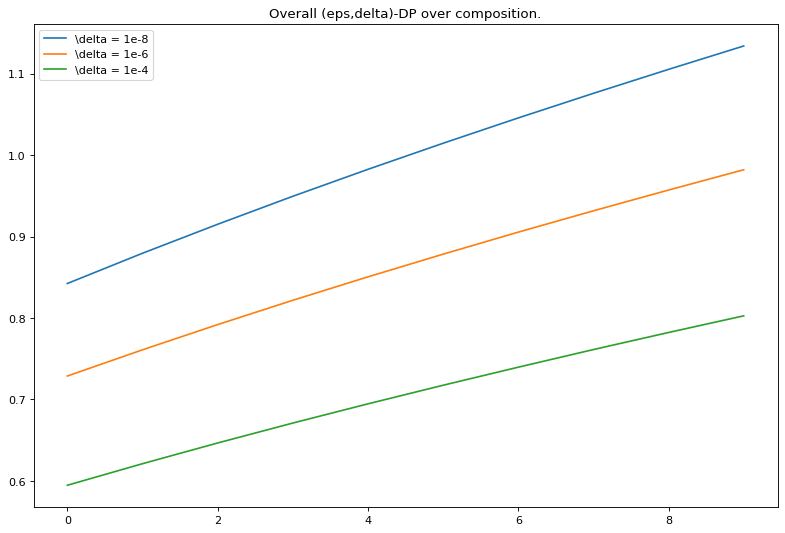

In [5]:
# decalre another moment accountant
acct2 = rdp_acct.anaRDPacct()
eps_seq = []
eps_seq2= []
eps_seq3= []

delta1 = 1e-8
delta2 = 1e-6
delta3 = 1e-4

sigma = 5.0
func = lambda x: rdp_bank.RDP_gaussian({'sigma': sigma}, x)
k=1000
prob = 0.01

acct2.compose_subsampled_mechanism(func,prob,coeff=k)

for i in range(int(k/100)):
    acct2.compose_subsampled_mechanism(func,prob,coeff=100)
    eps_seq.append(acct2.get_eps(delta1))
    eps_seq2.append(acct2.get_eps(delta2))
    eps_seq3.append(acct2.get_eps(delta3))
    #if i%100==0:
    print("[",i,"]Privacy loss is",(eps_seq[-1],eps_seq2[-1],eps_seq3[-1]))


print("Composition of 1000 subsampled Gaussian mechanisms gives ", (acct2.get_eps(delta), delta))

import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(num=1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(eps_seq)
plt.plot(eps_seq2)
plt.plot(eps_seq3)

plt.legend(['\delta = 1e-8', '\delta = 1e-6', '\delta = 1e-4'], loc='best')
plt.title('Overall (eps,delta)-DP over composition.')
plt.show()